In [79]:
import csv
import pandas as pd
import re
import io
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import unidecode
import re

Se hace la lectura de esta manera debido a que por algun motivo si se intenta leer el archivo con read_csv se presentan problemas 

In [80]:
file_path = 'C:\\Users\\juanp\\OneDrive\\Desktop\\CURSO TURING\\datos.csv'

In [81]:
data = pd.read_csv(file_path, encoding='latin1', sep=',', skiprows=1)
print(data.head())
data = pd.read_csv(file_path, encoding='utf-8', sep='"', skiprows=1, header=None)
print(data.head())
data = pd.read_csv(file_path, encoding='utf-8', sep=',', skiprows=0)

data.head()


  https://www.ciencuadras.com/inmueble/casa-campestre-en-venta-en-el-retiro-el-retiro-3305988,"Casa campestre en venta, Loma del escobero",$3.300.000.000,"Envigado, Loma Del Escobero, Las Palmas ",4,4,2,450.0,"En una de las zonas mÃ¡s tranquilas y exclusivas de El Retiro, Antioquia, se encuentra esta hermosa Casa Campestre, lista para ser el hogar de tus sueÃ±os. Con una impresionante vista panorÃ¡mica, esta propiedad cuenta con un Ã¡rea de terreno de 6414 M2, perfecta para aquellos que buscan un amplio espacio para disfrutar de la naturaleza y la privacidad que ofrece una vida campestre. Con una construcciÃ³n de 450 M2 distribuidos en una sola planta, esta casa cuenta con un diseÃ±o moderno y elegante, con amplias y luminosas habitaciones y un total de 4 baÃ±os de diseÃ±o exclusivo. AdemÃ¡s, cuenta con una cochera y garaje con capacidad para 2 vehÃ­culos, para mayor comodidad y seguridad. En su interior, encontrarÃ¡s todas las comodidades que necesitas para una vida cÃ³moda y relajada

,url,Tipo de propiedad,Precio,Ubicación,Habitaciones,Baños,Parqueaderos,Área,Descripción;;;;;;;
0,https://www.ciencuadras.com/inmueble/casa-camp...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://www.ciencuadras.com/inmueble/casa-en-v...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.ciencuadras.com/inmueble/casa-camp...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://www.ciencuadras.com/inmueble/casa-en-v...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://www.ciencuadras.com/inmueble/casa-en-v...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


No se la procedencia del problema por lo que se va a a proceder a realizar una lectura del archivo como texto para posteriormente construir el data frame

In [82]:
# Lectura de datos
# -*- coding: utf-8 -*-

# Vamos a leer el archivo como texto completo
with open(file_path, 'r', encoding='utf-8') as file:
    content = file.read() # Es un proceso lento y consume mucha memoria

# Dividir por líneas
lines = content.strip().split('\n')
headers = lines[0].split(',')

print(headers) # Aqui se consiguen los headers, hay tildes, caracteres especiales y errores de codificación

['url', 'Tipo de propiedad', 'Precio', 'Ubicación', 'Habitaciones', 'Baños', 'Parqueaderos', 'Área', 'Descripción;;;;;;;']


En headers quedaron guardados los nombres de las columnas y en lines el contenido del archivo. Para el analisis de lines se puede escoger cualquier linea pero se escogio esta debido que hay tildes y caracteres especiales y como se se va a realizar una limpieza de los datos se prefiere para ver como quedan los datos y que no se pierda el sentido.
Ejemplo si se hace un tratamiento de datos para eliminar caracteres especiales puede que quede Bogotá como Bogot o o algo similar y no se quiere eso. Por eso se escoge una linea con caracteres especiales y tildes para ver como queda el resultado final.

In [83]:
print(lines[5:6])  

['"https://www.ciencuadras.com/inmueble/casa-en-venta-en-niza-bogota-3286559,""Casa en venta, Niza"",$1.290.000.000,""Bogotá, Mónaco, Puente Largo "",4,3,2,445.0,Casa de ensueño en Bogota.";;;;;;;']


In [84]:
# Limpiar encabezados (eliminar los puntos y coma adicionales)
headers_line = lines[0]
headers = headers_line.split(',')
headers[-1] = re.sub(r';+$', '', headers[-1])  # Limpiamos los ;;; del último encabezado
headers

['url',
 'Tipo de propiedad',
 'Precio',
 'Ubicación',
 'Habitaciones',
 'Baños',
 'Parqueaderos',
 'Área',
 'Descripción']

Definimos una función para “romper” cada línea de texto en sus columnas, manejando comas internas y comillas. <br>
La manera tradicional de hacerlo es analizando la estructura del csv pero yo prefiero usar IA para hacerlo, ejemplo1


In [85]:
def parse_property_line(line):
    # Inicializamos un array para los resultados
    result = [""] * len(headers)
    
    # Quitar comillas externas si existen
    if line.startswith('"') and line.endswith('"'):
        line = line[1:-1]
    
    # Eliminar punto y coma extras al final
    line = re.sub(r';+$', '', line)
    
    # Identificar partes clave utilizando patrones específicos
    
    # 1. Extraer URL (hasta la primera coma)
    comma_pos = line.find(',')
    if comma_pos != -1:
        result[0] = line[:comma_pos]  # URL
        remainder = line[comma_pos+1:]
    else:
        return result
    
    # 2. Extraer Tipo de propiedad (entre comillas)
    tipo_match = re.search(r'"([^"]+)"', remainder)
    if tipo_match:
        result[1] = tipo_match.group(1)  # Tipo de propiedad
        remainder = remainder[tipo_match.end()+1:]
    else:
        return result
    
    # 3. Extraer Precio (comienza con $)
    precio_match = re.search(r'\$([\d,.]+)', remainder)
    if precio_match:
        result[2] = "$" + precio_match.group(1)  # Precio
        remainder = remainder[precio_match.end()+1:]
    else:
        return result
    
    # 4. Extraer Ubicación (entre comillas)
    ubicacion_match = re.search(r'"([^"]+)"', remainder)
    if ubicacion_match:
        result[3] = ubicacion_match.group(1)  # Ubicación
        remainder = remainder[ubicacion_match.end()+1:]
    else:
        return result
    
    # 5-8. Extraer los valores numéricos o "No encontrado"
    # Buscar hasta donde comienza la descripción final
    desc_start = remainder.find('"')
    
    if desc_start > 0:
        # Tenemos campos numéricos y descripción
        numeric_part = remainder[:desc_start].strip()
        if numeric_part.startswith(','):
            numeric_part = numeric_part[1:]
        
        # Dividir los valores numéricos por comas
        numeric_values = numeric_part.split(',')
        
        # Asignar los valores a sus campos correspondientes
        for i, val in enumerate(numeric_values[:4], 4):
            if i < len(result):
                result[i] = val.strip()
        
        # 9. Extraer la Descripción (entre comillas al final)
        desc_match = re.search(r'"([^"]+)"', remainder[desc_start:])
        if desc_match:
            result[8] = desc_match.group(1)  # Descripción
    else:
        # Si no hay descripción, asumimos que todos los valores restantes son numéricos
        if remainder.startswith(','):
            remainder = remainder[1:]
        numeric_values = remainder.split(',')
        for i, val in enumerate(numeric_values[:4], 4):
            if i < len(result):
                result[i] = val.strip()
    
    return result

In [86]:
# Procesar todas las líneas y crear el DataFrame
data = []
for i, line in enumerate(lines[1:], 1):
    if not line.strip():  # Saltar líneas vacías
        continue
    
    try:
        row = parse_property_line(line)
        data.append(row)
    except Exception as e:
        print(f"Error en línea {i}: {e}")
        print(f"Contenido de la línea: {line[:100]}...")

# Crear el DataFrame
df = pd.DataFrame(data, columns=headers)

# Limpiar datos adicionales
# Eliminar comillas innecesarias y espacios en blanco en campos de texto
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace('"', '').str.strip()



# Mostrar información sobre los datos procesados
print(f"\nSe procesaron {len(data)} líneas de {len(lines)-1} líneas de datos")
print("\nPrimeras filas del DataFrame:")
print(df.head())
print("\nInformación del DataFrame:")
print(df.info())





Se procesaron 553 líneas de 553 líneas de datos

Primeras filas del DataFrame:
                                                 url  \
0  https://www.ciencuadras.com/inmueble/casa-camp...   
1  https://www.ciencuadras.com/inmueble/casa-en-v...   
2  https://www.ciencuadras.com/inmueble/casa-camp...   
3  https://www.ciencuadras.com/inmueble/casa-en-v...   
4  https://www.ciencuadras.com/inmueble/casa-en-v...   

                            Tipo de propiedad           Precio  \
0  Casa campestre en venta, Loma del escobero  $3.300.000.000,   
1         Casa en venta, Hacienda el castillo    $350.000.000,   
2             Casa campestre en venta, Centro  $1.200.000.000,   
3             Casa en venta, Vereda la planta    $194.000.000,   
4                         Casa en venta, Niza  $1.290.000.000,   

                                           Ubicación Habitaciones Baños  \
0            Envigado, Loma Del Escobero, Las Palmas            4     4   
1  Cn Solares De La Morada Et Vii Y 

In [87]:
df.head(10)

,url,Tipo de propiedad,Precio,Ubicación,Habitaciones,Baños,Parqueaderos,Área,Descripción
0,https://www.ciencuadras.com/inmueble/casa-camp...,"Casa campestre en venta, Loma del escobero","$3.300.000.000,","Envigado, Loma Del Escobero, Las Palmas",4,4,2,450.0,En una de las zonas más tranquilas y exclusiva...
1,https://www.ciencuadras.com/inmueble/casa-en-v...,"Casa en venta, Hacienda el castillo","$350.000.000,","Cn Solares De La Morada Et Vii Y Viii, Br Send...",2,3,2,100.0,"SE VENDE, Hermosa casa en el castillo Zona Jam..."
2,https://www.ciencuadras.com/inmueble/casa-camp...,"Casa campestre en venta, Centro","$1.200.000.000,","La Calera, La Plazuela, Alto De La Virgen",4,8,12,5127.0,Expectacular casa-finca campestre vía Bogotá- ...
3,https://www.ciencuadras.com/inmueble/casa-en-v...,"Casa en venta, Vereda la planta","$194.000.000,","Loma Del Atravesado, Las Palmas, La Mesa",3,1,No encontrado,78.0,Esta encantadora casa cuenta con servicios com...
4,https://www.ciencuadras.com/inmueble/casa-en-v...,"Casa en venta, Niza","$1.290.000.000,","Bogotá, Mónaco, Puente Largo",4,3,2,445.0,
5,https://www.ciencuadras.com/inmueble/casa-en-v...,"Casa en venta, Trece de noviembre","$170.000.000,","Boston, Buenos Aires, Miraflores",3,2,No encontrado,75.0,casa con 2 pisos independientes con espacios g...
6,https://www.ciencuadras.com/inmueble/casa-en-v...,"Casa en venta, Juanambú","$700.000.000,","San Pedro, San Vicente, Santa Mónica",7,8,2,359.7,"Casa en venta, ubicada en el barrio Juanambú, ..."
7,https://www.ciencuadras.com/inmueble/casa-en-v...,"Casa en venta, Pumarejo","$500.000.000,","Barranquilla, El Recreo, San Jose",3,5,3,200.0,"En la ciudad de Barranquilla, se encuentra est..."
8,https://www.ciencuadras.com/inmueble/casa-en-v...,"Casa en venta, Otros","$168.000.000,","Espinal, Br El Portal Del Bunde, Caballero Y G...",3,4,2,94.0,"CASA DE DOS PISOS, CON EXCELENTE ÁREA, UBICACI..."
9,https://www.ciencuadras.com/inmueble/casa-en-v...,"Casa en venta, Pietra santa","$890.000.000,","El Porvenir, San Antonio, Rionegro",4,8,2,203.0,Se vende casa en parcelación cerrada en San An...


In [88]:
print(f"Dimensiones iniciales: {df.shape}")


Dimensiones iniciales: (553, 9)


In [89]:
# 1. Remover url columna
df.drop(columns=['url'], inplace=True)

In [90]:
# 2. Renombrar columnas para facilitar el análisis

df.columns = ['tipo_raw', 'precio', 'ubicacion', 'habitaciones', 'baños', 'parqueaderos', 'area', 'descripcion']
df.head(10)

,tipo_raw,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion
0,"Casa campestre en venta, Loma del escobero","$3.300.000.000,","Envigado, Loma Del Escobero, Las Palmas",4,4,2,450.0,En una de las zonas más tranquilas y exclusiva...
1,"Casa en venta, Hacienda el castillo","$350.000.000,","Cn Solares De La Morada Et Vii Y Viii, Br Send...",2,3,2,100.0,"SE VENDE, Hermosa casa en el castillo Zona Jam..."
2,"Casa campestre en venta, Centro","$1.200.000.000,","La Calera, La Plazuela, Alto De La Virgen",4,8,12,5127.0,Expectacular casa-finca campestre vía Bogotá- ...
3,"Casa en venta, Vereda la planta","$194.000.000,","Loma Del Atravesado, Las Palmas, La Mesa",3,1,No encontrado,78.0,Esta encantadora casa cuenta con servicios com...
4,"Casa en venta, Niza","$1.290.000.000,","Bogotá, Mónaco, Puente Largo",4,3,2,445.0,
5,"Casa en venta, Trece de noviembre","$170.000.000,","Boston, Buenos Aires, Miraflores",3,2,No encontrado,75.0,casa con 2 pisos independientes con espacios g...
6,"Casa en venta, Juanambú","$700.000.000,","San Pedro, San Vicente, Santa Mónica",7,8,2,359.7,"Casa en venta, ubicada en el barrio Juanambú, ..."
7,"Casa en venta, Pumarejo","$500.000.000,","Barranquilla, El Recreo, San Jose",3,5,3,200.0,"En la ciudad de Barranquilla, se encuentra est..."
8,"Casa en venta, Otros","$168.000.000,","Espinal, Br El Portal Del Bunde, Caballero Y G...",3,4,2,94.0,"CASA DE DOS PISOS, CON EXCELENTE ÁREA, UBICACI..."
9,"Casa en venta, Pietra santa","$890.000.000,","El Porvenir, San Antonio, Rionegro",4,8,2,203.0,Se vende casa en parcelación cerrada en San An...


In [91]:
# 3. Separar 'tipo_raw' en tipo de propiedad y sector
df[['tipo_propiedad', 'georeferencia']] = df['tipo_raw'].str.split(',', expand=True)
df.drop(columns='tipo_raw', inplace=True)
df.head(10)

,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia
0,"$3.300.000.000,","Envigado, Loma Del Escobero, Las Palmas",4,4,2,450.0,En una de las zonas más tranquilas y exclusiva...,Casa campestre en venta,Loma del escobero
1,"$350.000.000,","Cn Solares De La Morada Et Vii Y Viii, Br Send...",2,3,2,100.0,"SE VENDE, Hermosa casa en el castillo Zona Jam...",Casa en venta,Hacienda el castillo
2,"$1.200.000.000,","La Calera, La Plazuela, Alto De La Virgen",4,8,12,5127.0,Expectacular casa-finca campestre vía Bogotá- ...,Casa campestre en venta,Centro
3,"$194.000.000,","Loma Del Atravesado, Las Palmas, La Mesa",3,1,No encontrado,78.0,Esta encantadora casa cuenta con servicios com...,Casa en venta,Vereda la planta
4,"$1.290.000.000,","Bogotá, Mónaco, Puente Largo",4,3,2,445.0,,Casa en venta,Niza
5,"$170.000.000,","Boston, Buenos Aires, Miraflores",3,2,No encontrado,75.0,casa con 2 pisos independientes con espacios g...,Casa en venta,Trece de noviembre
6,"$700.000.000,","San Pedro, San Vicente, Santa Mónica",7,8,2,359.7,"Casa en venta, ubicada en el barrio Juanambú, ...",Casa en venta,Juanambú
7,"$500.000.000,","Barranquilla, El Recreo, San Jose",3,5,3,200.0,"En la ciudad de Barranquilla, se encuentra est...",Casa en venta,Pumarejo
8,"$168.000.000,","Espinal, Br El Portal Del Bunde, Caballero Y G...",3,4,2,94.0,"CASA DE DOS PISOS, CON EXCELENTE ÁREA, UBICACI...",Casa en venta,Otros
9,"$890.000.000,","El Porvenir, San Antonio, Rionegro",4,8,2,203.0,Se vende casa en parcelación cerrada en San An...,Casa en venta,Pietra santa


Se notan tildes y caracteres especiales en las columnas tipo string

In [92]:
''' No recomendado por que va a eliminar tildes y caracteres especiales que va a generar ruido en la informacion '''
#for col in ['ubicacion', 'descripcion', 'georeferencia']:
#    data[col] = data[col].str.encode('latin1').str.decode('utf-8') 

' No recomendado por que va a eliminar tildes y caracteres especiales que va a generar ruido en la informacion '

In [93]:
# Ahora verificamos que no haya valores nulos en ninguna de las columnas
df.isnull().sum()


precio            0
ubicacion         0
habitaciones      0
baños             0
parqueaderos      0
area              0
descripcion       0
tipo_propiedad    0
georeferencia     0
dtype: int64

Realmente no hay datos nulos?

In [94]:
df[~df['area'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]

,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia
21,"$4.500.000.000,","FINCA A LA VENTA, SECTOR DON DIEGO PALOMINO, C...",,,,,,Finca en venta,Bonda sector macinga
40,"$4.500.000.000,","FINCA A LA VENTA, SECTOR DON DIEGO PALOMINO, C...",,,,,,Finca en venta,Bonda sector macinga
86,"$930.000.000,","El Redil, Toberin, Nueva Zelandia",3,4,1,+50,Te presentamos esta confortable casa de 3 plan...,Casa en venta,San antonio nor - occidental
91,"$720.000.000,","Bosconia, El Tintal, Ub. Castilla Real",3,4,2,10-30,"Casa de tres pisos con amplios, variados y con...",Casa en venta,Villa alsacia 2
323,"$100.000.000,,1,1,",Te presentamos esta Finca ubicado en la direcc...,,,,,,Finca en venta,Santuario
330,"$488.488.000,",Te presentamos confortable casa ubicada en sec...,,,,,,Casa en venta,Pontevedra
351,"$66.900.000,,2,1,1,59.75,",Te presentamos esta confortable casa ubicada e...,,,,,,Casa en venta,San cayetano
359,"$208.200.000,,3,2,1,87.9,",Te presentamos confortable apartamento ubicado...,,,,,,Apartamento en venta,Tena
378,"$240.000.000,","Iqueima, Panamericana, Flandes",4,6,2,10-30,Te presentamos esta confortable casa ubicada e...,Casa en venta,Altagracia
393,"$1.100.000.000,","Pereira, Avenida 30 De Agosto, Ur Rincon De La...",5,17,5,10-30,Te presentamos esta confortable casa campestre...,Casa en venta,Corregimiento combia alta


In [95]:
#  Valores unicos de cada columna
df.nunique()  

precio            284
ubicacion         361
habitaciones       22
baños              20
parqueaderos       16
area              279
descripcion       452
tipo_propiedad     17
georeferencia     341
dtype: int64

In [96]:
for col in df.columns:
    print(f"Valores unicos de la columna {col}: {df[col].unique()}")
    

Valores unicos de la columna precio: ['$3.300.000.000,' '$350.000.000,' '$1.200.000.000,' '$194.000.000,'
 '$1.290.000.000,' '$170.000.000,' '$700.000.000,' '$500.000.000,'
 '$168.000.000,' '$890.000.000,' '$480.000.000,' '$1.150.000.000,'
 '$900.000.000,' '$800.000.000,' '$1.500.000.000,' '$280.000.000,'
 '$250.000.000,' '$680.000.000,' '$180.000.000,' '$235.000.000,'
 '$4.500.000.000,' '$850.000.000,' '$300.000.000,' '$1.900.000.000,'
 '$445.000.000,' '$2.400.000,' '$198.000.000,' '$780.000.000,'
 '$820.000.000,' '$340.000.000,' '$450.000.000,' '$1.300.000.000,'
 '$10.200.000,' '$4.300.000,' '$5.000.000,' '$4.100.000,' '$6.000.000,'
 '$9.800.000,' '$9.500.000,' '$9.400.000,' '$18.000.000,' '$10.000.000,'
 '$6.400.000,' '$7.300.000,' '$10.500.000,' '$7.200.000,'
 '$1.800.000.000,' '$650.000.000,' '$758.000.000,' '$1.100.000.000,'
 '$1.680.000.000,' '$460.000.000,' '$530.000.000,' '$210.000.000,'
 '$1.275.000.000,' '$550.000.000,' '$1.400.000.000,' '$930.000.000,'
 '$320.000.000,' '$38

Se sabe que si hay datos vacios <br>
Procedemos con hacer limpieza a otras columnas

In [97]:
# 5. Limpiar valores numéricos
df['precio'] = df['precio'].replace('[\$,\.]', '', regex=True)

df['precio'].head(10)

0    3300000000
1     350000000
2    1200000000
3     194000000
4    1290000000
5     170000000
6     700000000
7     500000000
8     168000000
9     890000000
Name: precio, dtype: object

In [98]:
# Unicos valores area
df['area'].unique()  

array(['450.0', '100.0', '5127.0', '78.0', '445.0', '75.0', '359.7',
       '200.0', '94.0', '203.0', '155.0', '136.0', '160.0', '215.0',
       '253.0', '90.0', '92.0', '111.81', '180.0', '62.0', '', '61.0',
       '145.0', '56.0', '2957.0', '213.89', '60.0', '29.0', '67.0',
       '144.0', '152.0', '47.0', '72.0', '88.0', '150.0', '83.0', '148.0',
       '280.0', '85.0', '260.0', '166.0', '130.0', '80.0', '156.0',
       '384.75', '183.0', '57.0', '188.94', '500.0', '400.0', '91.94',
       '154.0', '358.0', '110.0', '360.0', '+50', '98.0', '127.0',
       '770.0', '158.4', '10-30', '179.0', '404.2', '55.0', '50.0',
       '44.0', '65.0', '52.0', '49.0', '45.0', '64.0', '230.2', '350.0',
       '198.0', '96.15', '168.5', '120.0', '112.68', '390.0', '367.0',
       '128.25', '66.0', '330.0', '288.0', '38.0', '25.0', '54.0', '39.0',
       '31.0', '70.0', '40.0', '30.0', '34.0', '42.0', '82.0', '106.0',
       '41.0', '48.0', '79.0', '93.0', '135.0', '347.0', '96.0', '95.0',
       '53

In [99]:
# Mostrando que valores no son numericos
df[~df['area'].str.replace('.', '', regex=False).str.isnumeric() & (df['area'].str.len() > 0)]

,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia
86,930000000,"El Redil, Toberin, Nueva Zelandia",3,4,1,+50,Te presentamos esta confortable casa de 3 plan...,Casa en venta,San antonio nor - occidental
91,720000000,"Bosconia, El Tintal, Ub. Castilla Real",3,4,2,10-30,"Casa de tres pisos con amplios, variados y con...",Casa en venta,Villa alsacia 2
378,240000000,"Iqueima, Panamericana, Flandes",4,6,2,10-30,Te presentamos esta confortable casa ubicada e...,Casa en venta,Altagracia
393,1100000000,"Pereira, Avenida 30 De Agosto, Ur Rincon De La...",5,17,5,10-30,Te presentamos esta confortable casa campestre...,Casa en venta,Corregimiento combia alta
395,184700000,"Miraflores , Girardot, Togorama",5,4,2,10-30,INMUEBLE DAVIVIENDA. Te presentamos esta casa ...,Casa en venta,Las quintas
399,295000000,"Aurora Et. I, La Picota Sur, Los Molinos Del Sur",5,4,2,1-10,Te presentamos esta confortable casa ubicada e...,Casa en venta,Danubio azul
400,250000000,"El Ensueño, Madelena Iii Y Iv, Atlanta",5,8,1,10-30,Te presentamos esta confortable casa de 5 piso...,Casa en venta,Sierra morena
403,300000000,"La Victoria, Altamira, Arrayanes",5,6,4,1-10,Te presentamos esta confortable casa ubicada e...,Casa en venta,Santa rita sur oriental ii etapa
404,12284462709,"Anapoima, Cn Las Acacias, Cn Anapoima",5,8,1,10-30,"Te presentamos esta Finca ubicada en Anapoima,...",Finca en venta,Colombia
409,790000000,"El Porvenir, Centro Fontibon, Alameda",5,8,3,1-10,Te presentamos esta confortable propiedad ubic...,Casa en venta,La perla


Convertimos cadenas de área con formato ancho-largo a metros² para los datos de 10-30 ya que es una denominacion usada en bienes raices y para 1-10 hay que pensar dado a que el calculo seria 1*10, que significa 1-10? 100 metros? Tras investigar es mas usada esta denominacion para hectarias significando que son 1 hectaria 

In [100]:
# Que es 10-30? Vamos a verificar ese dato
df[df['area'] == '10-30']  # 10-30 significa 10 ancho x 30 de largo, vamos a transformar eso a metros cuadrados
# 10-30 significa 10 ancho x 30 de largo, vamos a transformar eso a metros cuadrados
# Vamos a crear una funcion que haga eso
def transform_area(area):
    if area == '10-30':  # Check specifically for '10-30'
        ancho, largo = map(int, area.split('-'))
        return ancho * largo
    elif area == '1-10':  # Check specifically for '1-10'
        return 1000  # 1 hectárea is equivalent to 1000 square meters
    return area  # Return the original value if it's not '10-30' or '1-10'
# Tambien se podria aplicar un cambio de variable a cuando la columna diga 10-30 poner un 300, sin embargo se prefiere este metodo por ser mas explicativo y poder generalizarlo a otros casos
# Aplicamos la funcion a la columna area
df['area'] = df['area'].apply(transform_area)
df['area'].unique()  # Verificamos que ahora los valores sean enteros


array(['450.0', '100.0', '5127.0', '78.0', '445.0', '75.0', '359.7',
       '200.0', '94.0', '203.0', '155.0', '136.0', '160.0', '215.0',
       '253.0', '90.0', '92.0', '111.81', '180.0', '62.0', '', '61.0',
       '145.0', '56.0', '2957.0', '213.89', '60.0', '29.0', '67.0',
       '144.0', '152.0', '47.0', '72.0', '88.0', '150.0', '83.0', '148.0',
       '280.0', '85.0', '260.0', '166.0', '130.0', '80.0', '156.0',
       '384.75', '183.0', '57.0', '188.94', '500.0', '400.0', '91.94',
       '154.0', '358.0', '110.0', '360.0', '+50', '98.0', '127.0',
       '770.0', '158.4', 300, '179.0', '404.2', '55.0', '50.0', '44.0',
       '65.0', '52.0', '49.0', '45.0', '64.0', '230.2', '350.0', '198.0',
       '96.15', '168.5', '120.0', '112.68', '390.0', '367.0', '128.25',
       '66.0', '330.0', '288.0', '38.0', '25.0', '54.0', '39.0', '31.0',
       '70.0', '40.0', '30.0', '34.0', '42.0', '82.0', '106.0', '41.0',
       '48.0', '79.0', '93.0', '135.0', '347.0', '96.0', '95.0', '53.0',
      

In [101]:
df[(df['area'] == '+50')] # Mas de 50 es ambiguo, que se puede hacer?
# Una propuesta en buscar el promedio de los valores de la columna area y ponerlo como valor para el resto de los casos
# Otra propuesta es, buscar otros datos que tengan caracteristicas similares y ver que valor tienen en la columna area
# En este caso que serian datos con 3 habitaciones, 4 baños y 2 parqueaderos



,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia
86,930000000,"El Redil, Toberin, Nueva Zelandia",3,4,1,+50,Te presentamos esta confortable casa de 3 plan...,Casa en venta,San antonio nor - occidental


In [102]:
df[(df['habitaciones'] == 3) & (df['baños'] == 4) & (df['parqueaderos'] == 2)] # Vamos a ver que valores tienen en la columna area
# No hay mas entonces si se añade un valor mas de 50 podria estar añadiendose ruido por lo que muchas opciones pero yo voy a obtar por eliminar el dato



,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia


In [103]:
# Eliminamos los datos que no tienen sentido
# Una opcion podria ser darle un valor de 0 a los datos que dicen 1-10 para que no afecten el análisis
# Ahora queda faltando que hacer con los datos que dicen 1-10
df.drop(df[(df['area'] == '+50')].index, inplace=True)

In [104]:
# Checando por duplicados
print(df.duplicated().sum())

# Crear una función para mostrar los datos duplicados y cuántas veces se repiten
def show_duplicates(df):
    duplicates = df[df.duplicated(keep=False)]
    duplicate_counts = duplicates.groupby(list(df.columns)).size().reset_index(name='count')
    return duplicate_counts

# Llamar a la función y mostrar los resultados
show_duplicates(df)

73


,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,count
0,1097655000,"La Mesa, El Centro, Santa Barbara",6,8,5,297.9,¡¡¡GRAN OFERTA!!! Finca grande con una área de...,Finca en venta,Toledo,2
1,11000000,"Los Rosales, Chapinero Central, Chico",9,6,2,315.0,El nogal - En uno de los sectores mas exclusiv...,Casa en arriendo,El nogal,3
2,12000000,"Altos Del Prado, El Prado, Villa Country",9,3,2,700.0,Hermosa casa comercial en arriendo o venta ubi...,Casa en arriendo,El prado,2
3,12000000,"Laureles, Rosales, Las Acacias",7,21,3,500.0,"BEMSA PROPIEDAD RAÍZ vende espectacular, casa ...",Casa en arriendo,La castellana,2
4,1200000000,"La Calera, La Plazuela, Alto De La Virgen",4,8,12,5127.0,Expectacular casa-finca campestre vía Bogotá- ...,Casa campestre en venta,Centro,3
...,...,...,...,...,...,...,...,...,...,...
57,820000000,"Chico Norte Et. Ii, Chico Norte Et. Iii, Santa...",3,4,1,152.0,"Para la Venta, hermoso apartamento con amplia ...",Apartamento en venta,Rincon del chicó,2
58,8500000,"El Tesoro, Castropol, Alejandria",10,6,1,210.0,Codigo 24444. Casa comercial en arriendo ubica...,Casa en arriendo,El poblado,3
59,8500000,"Molinos Norte, Bella Suiza, San Patricio",14,15,11,400.0,Espectacular casa para uso residencial o comer...,Casa en arriendo,Santa barbara oriental usaquén,2
60,8500000,"Santa Rosa De Lima, Calasanz, Estadio",11,9,1,238.0,Se Arrienda Casa - Local en Calasanz con fácil...,Casa en arriendo,Calasanz,3


In [106]:
print(df.shape)


(552, 9)


In [108]:
# Quedandonos solo con uno de todos los duplicados
df = df.drop_duplicates(keep='first')
print(df.shape)  # Check the shape after removing duplicates


(479, 9)


Ahora nos enfrentamos al problema de ubicación en donde no se tiene la información con algun formato

In [28]:
df.head(5)
# ubicacion no esta en orden tiene informacion como barrio, ciudad y otra ubicacion [Separados por ',' pero estas estan en desorden]


,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia
0,3300000000,"Envigado, Loma Del Escobero, Las Palmas",4,4,2,450.0,En una de las zonas más tranquilas y exclusiva...,Casa campestre en venta,Loma del escobero
1,350000000,"Cn Solares De La Morada Et Vii Y Viii, Br Send...",2,3,2,100.0,"SE VENDE, Hermosa casa en el castillo Zona Jam...",Casa en venta,Hacienda el castillo
2,1200000000,"La Calera, La Plazuela, Alto De La Virgen",4,8,12,5127.0,Expectacular casa-finca campestre vía Bogotá- ...,Casa campestre en venta,Centro
3,194000000,"Loma Del Atravesado, Las Palmas, La Mesa",3,1,No encontrado,78.0,Esta encantadora casa cuenta con servicios com...,Casa en venta,Vereda la planta
4,1290000000,"Bogotá, Mónaco, Puente Largo",4,3,2,445.0,,Casa en venta,Niza


In [29]:
# Descargar recursos necesarios
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
# Definir stopwords en español
stop_words = set(stopwords.words('spanish'))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\juanp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juanp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\juanp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Tokenizacion y limpieza de cada columna str

Aca hay que tener mucho cuidado ya que la limpieza puede eliminar información relevante para el proximo analisis, es importante tener en cuenta que lo que nosotros consideremos importante limpiar para una base de datos mas limpia no necesariamente se alinea con los datos que son relevantes para modelar pero no es necesario tener esto en cuenta desde el inicio ya que la limpieza de datos y modelamiento son procesos iterativos, lo importante de tener estas funciones donde se hace este proceso es que cuando notemos que algo nos falta o es necesario un paso extra podemos venir y realizar las modificaciones mas comododamente <br>
Como ejemplo y espoiler: Si se eliminan numeros estariamos eliminando información de la descripción que nos puede ayudar a hacer imputacion de datos <br>
Bajo mi experiencia lo mas comodo es realizar una primera limpieza que le de estructura a los datos, y luego en el modelamiento volver a hacer otra limpieza que nos sea util para modelar, como disminuir dimensionalidad y quitar informacion irrelevante

In [30]:
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def limpiar_y_tokenizar(texto, domain_stopwords=None):
    """
    Limpia y tokeniza un texto eliminando puntuación, números,
    unidades como m2, y stopwords generales y específicas de dominio.
    """
    # Convertir a minúsculas
    texto = texto.lower()
    
    # Eliminar unidades típicas del sector (m2, mts2, m², etc.)
    #texto = re.sub(r'\b\d+\s*(m2|mts2|mts|m²|mt2|metros cuadrados)\b', '', texto)
    

    # Eliminar palabras como cn, el, la, br, las, los, etc.
    texto = re.sub(r'\b(cn|el|la|br|las|los|cn.)\b', '', texto)
    
    # Eliminar signos de puntuación y caracteres especiales
    texto = texto.translate(str.maketrans('', '', string.punctuation + '¡¿·—“”‘’°º'))

    # Tokenizar
    tokens = word_tokenize(texto, language='spanish')

    # Stopwords generales
    stop_words = set(stopwords.words('spanish'))

    # Agregar stopwords específicas del dominio si las hay
    if domain_stopwords is not None:
        stop_words = stop_words.union(set(domain_stopwords))

    # Filtrar tokens
    tokens_filtrados = [
        token for token in tokens 
        if token not in stop_words and token.strip() != ''
    ]

    return tokens_filtrados


domain_words = {"vende", "venta", "propiedad", "inmueble", "inmobiliaria", "disponible", "m2", "mts", "m²"}
tokens_resultantes = limpiar_y_tokenizar(df['descripcion'].iloc[0], domain_stopwords=domain_words)

print(tokens_resultantes)


['zonas', 'tranquilas', 'exclusivas', 'retiro', 'antioquia', 'encuentra', 'hermosa', 'casa', 'campestre', 'lista', 'ser', 'hogar', 'sueños', 'impresionante', 'vista', 'panorámica', 'cuenta', 'área', 'terreno', '6414', 'perfecta', 'aquellos', 'buscan', 'amplio', 'espacio', 'disfrutar', 'naturaleza', 'privacidad', 'ofrece', 'vida', 'campestre', 'construcción', '450', 'distribuidos', 'sola', 'planta', 'casa', 'cuenta', 'diseño', 'moderno', 'elegante', 'amplias', 'luminosas', 'habitaciones', 'total', '4', 'baños', 'diseño', 'exclusivo', 'además', 'cuenta', 'cochera', 'garaje', 'capacidad', '2', 'vehículos', 'mayor', 'comodidad', 'seguridad', 'interior', 'encontrarás', 'todas', 'comodidades', 'necesitas', 'vida', 'cómoda', 'relajada', 'armarios', 'empotrados', 'todas', 'habitaciones', 'podrás', 'mantener', 'orden', 'aprovechar', 'máximo', 'espacio', 'baños', 'auxiliares', 'baño', 'habitación', 'principal', 'equipados', 'mejores', 'acabados', 'accesorios', 'alta', 'calidad', 'además', 'cuent

In [31]:
# Apply the cleaning and tokenization function to the 'descripcion' column
df['descripcion'] = df['descripcion'].apply(
    lambda x: ' '.join(limpiar_y_tokenizar(x, domain_stopwords=domain_words))
)

# Display the updated DataFrame
df.head()

,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia
0,3300000000,"Envigado, Loma Del Escobero, Las Palmas",4,4,2,450.0,zonas tranquilas exclusivas retiro antioquia e...,Casa campestre en venta,Loma del escobero
1,350000000,"Cn Solares De La Morada Et Vii Y Viii, Br Send...",2,3,2,100.0,hermosa casa castillo zona jamundí sur ciudad ...,Casa en venta,Hacienda el castillo
2,1200000000,"La Calera, La Plazuela, Alto De La Virgen",4,8,12,5127.0,expectacular casafinca campestre vía bogotá ca...,Casa campestre en venta,Centro
3,194000000,"Loma Del Atravesado, Las Palmas, La Mesa",3,1,No encontrado,78.0,encantadora casa cuenta servicios completos in...,Casa en venta,Vereda la planta
4,1290000000,"Bogotá, Mónaco, Puente Largo",4,3,2,445.0,,Casa en venta,Niza


In [32]:
print(df[['descripcion', 'georeferencia']].head())

                                         descripcion          georeferencia
0  zonas tranquilas exclusivas retiro antioquia e...      Loma del escobero
1  hermosa casa castillo zona jamundí sur ciudad ...   Hacienda el castillo
2  expectacular casafinca campestre vía bogotá ca...                 Centro
3  encantadora casa cuenta servicios completos in...       Vereda la planta
4                                                                      Niza


In [33]:
def limpiar_texto(texto):
    if pd.isnull(texto):
        return ''
    texto = texto.lower()
    texto = re.sub(r'\b(la|el|br\.|las|los|ub|barrio|urbanizacion|urb|ub|norte|sur|este|oeste|et\.? ii|et\.? iii|et\.?|cn|central)\b', '', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()  # elimina espacios múltiples
    return texto

# Aplicando en las variables
df['ubicacion'] = df['ubicacion'].apply(limpiar_texto)
df['georeferencia'] = df['georeferencia'].apply(limpiar_texto)

Aqui usamos unicodedata para quitar tildes reemplazandolas por sin el acento, poner en minusculas y remover espacios extras

In [34]:
import unicodedata

def normalizar_texto(texto):
    if pd.isnull(texto):
        return ''
    texto = texto.lower()
    texto = unicodedata.normalize('NFKD', texto)
    texto = ''.join(c for c in texto if not unicodedata.combining(c))
    return texto.strip()


In [35]:
df['ubicacion'] = df['ubicacion'].apply(normalizar_texto)
df['georeferencia'] = df['georeferencia'].apply(normalizar_texto)
df.head()


,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia
0,3300000000,"envigado, loma del escobero, palmas",4,4,2,450.0,zonas tranquilas exclusivas retiro antioquia e...,Casa campestre en venta,loma del escobero
1,350000000,"solares de morada vii y viii, br senderos de m...",2,3,2,100.0,hermosa casa castillo zona jamundí sur ciudad ...,Casa en venta,hacienda castillo
2,1200000000,"calera, plazuela, alto de virgen",4,8,12,5127.0,expectacular casafinca campestre vía bogotá ca...,Casa campestre en venta,centro
3,194000000,"loma del atravesado, palmas, mesa",3,1,No encontrado,78.0,encantadora casa cuenta servicios completos in...,Casa en venta,vereda planta
4,1290000000,"bogota, monaco, puente largo",4,3,2,445.0,,Casa en venta,niza


Por ahora parece que los datos estan mucho mas limpios sin embargo el dilema que se tiene en ubicacion es uno muy importante si se desea hacer modelamiento

# Limpieza de ubicacion

### Diccionarios

In [36]:
# Diccionarios de ciudades y municipios

ciudades_col = {
    "bogota": "ciudad",
    "medellin": "ciudad",
    "cali": "ciudad",
    "barranquilla": "ciudad",
    "cartagena": "ciudad",
    "cucuta": "ciudad",
    "bucaramanga": "ciudad",
    "pereira": "ciudad",
    "santa marta": "ciudad",
    "ibague": "ciudad",
    "manizales": "ciudad",
    "villavicencio": "ciudad",
    "neiva": "ciudad",
    "pasto": "ciudad",
    "monteria": "ciudad",
    "armenia": "ciudad",
    "sincelejo": "ciudad",
    "popayan": "ciudad",
    "valledupar": "ciudad",
    "quibdo": "ciudad",
    "riohacha": "ciudad",
    "tunja": "ciudad",
    "florencia": "ciudad",
    "yopal": "ciudad",
    "mocoa": "ciudad",
    "san jose del guaviare": "ciudad",
    "mitu": "ciudad",
    "puerto carreno": "ciudad",
    "leticia": "ciudad"
}

# Valle de aburra
municipios_valle_aburra = {
    "medellin": "municipio_valle_aburra",
    "bello": "municipio_valle_aburra",
    "itagui": "municipio_valle_aburra",
    "envigado": "municipio_valle_aburra",
    "sabaneta": "municipio_valle_aburra",
    "estrella": "municipio_valle_aburra",
    "copacabana": "municipio_valle_aburra",
    "girardota": "municipio_valle_aburra",
    "barbosa": "municipio_valle_aburra",
    "caldas": "municipio_valle_aburra",
    'rionegro ': 'municipio_valle_aburra'
}

barrios_valle_aburra = {
    # Medellín - Comunas y corregimientos
    "poblado": "medellin",
    "laureles": "medellin",
    "belen": "medellin",
    "robledo": "medellin",
    "estadio": "medellin",
    "centro": "medellin",
    "castilla": "medellin",
    "aranjuez": "medellin",
    "manrique": "medellin",
    "buenos aires": "medellin",
    "san javier": "medellin",
    "guayabal": "medellin",
    "villa hermosa": "medellin",
    "doce de octubre": "medellin",
    "popular": "medellin",
    "san cristobal": "medellin",
    "altavista": "medellin",
    "san antonio de prado": "medellin",
    "santa elena": "medellin",
    'calasanz': 'medellin',
    'palmas' : 'medellin',
    'candelaria': 'medellin',

    # Otros municipios del Valle de Aburrá
    "itagui": "itagui",
    "villa adelaida": "itagui",
    "ditaires": "itagui",
    "santa maria": "itagui",
    
    "envigado": "envigado",
    "zuniga": "envigado",
    "dorado": "envigado",
    "loma del escobero": "envigado",

    "sabaneta": "sabaneta",
    "alcala": "sabaneta",
    "pan de azucar": "sabaneta",

    "estrella": "estrella",
    "tablaza": "estrella",

    "bello": "bello",
    "niquia": "bello",
    "zamora": "bello",
    "bellavista": "bello",

    "copacabana": "copacabana",
    "machado": "copacabana",

    "girardota": "girardota",
    "hatillo": "girardota",

    "barbosa": "barbosa",
    "popalito": "barbosa",

    "caldas": "caldas",
    "raya": "caldas"
}


# Bogota
localidades_bogota = {
    "usaquen": "localidad_bogota",
    "chapinero": "localidad_bogota",
    "santa fe_bogota": "localidad_bogota",
    "san cristobal_bogota": "localidad_bogota",
    "usme": "localidad_bogota",
    "tunjuelito": "localidad_bogota",
    "bosa": "localidad_bogota",
    "kennedy": "localidad_bogota",
    "fontibon": "localidad_bogota",
    "engativa": "localidad_bogota",
    "suba": "localidad_bogota",
    "barrios unidos": "localidad_bogota",
    "teusaquillo": "localidad_bogota",
    "martires": "localidad_bogota",
    "antonio narino": "localidad_bogota",
    "puente aranda": "localidad_bogota",
    "candelaria": "localidad_bogota",
    "rafael uribe": "localidad_bogota",
    "ciudad bolivar": "localidad_bogota",
    "sumapaz": "localidad_bogota",
    'chapinero ' : 'localidad_bogota',
}



# Lista de barrios conocidos de Bogotá
barrios_bogota = {
    "usaquen", "santa ana", "santa bibiana", "la cabrera", "rincon del chico", "santa paula",
    "santa margarita", "san patricio", "santa ines", "santa monica", "santa rosa", "santa teresita",
    "el nogal", "el refugio", "quinta camacho", "marly", "el retiro", "el chico norte", "el chico sur",
    "el chico reservado", "el chico lago", "las aguas", "egipto", "la concordia", "la candelaria",
    "las nieves", "san victorino", "santa fe", "la macarena", "la merced", "san diego",
    "20 de julio", "san blas", "san isidro", "san martin", "san rafael", "san jorge", "san jose",
    "san luis", "san miguel", "san pedro", "usme centro", "danubio azul", "el bosque", "el triunfo",
    "la esperanza", "la flor", "la gloria", "la victoria", "los olivos", "el carmen", "el vergel",
    "la alqueria", "la fraguita", "la paz", "san carlos", "san ignacio", "bosa centro",
    "la libertad", "la primavera", "las margaritas", "los naranjos", "malvinas", "san antonio",
    "san bernardino", "americas", "boita", "britalia", "carvajal", "castilla", "ciudad kennedy",
    "la campina", "atahualpa", "belen", "capellania", "centro fontibon",
    "el ferrol", "granjas de techo", "hayuelos", "hipotecho", "kennedy central", "la giralda",
    "la felicidad", "la perlita", "las americas", "mandalay", "marsella", "modelia", "monaco",
    "muzu", "nuevo kennedy", "palermo sur", "patio bonito", "porvenir", "provenza", "recodo",
    "santa catalina", "santa matilde", "santa rosa de lima", "santander", "techo", "tintal",
    "tintala", "villa andrea", "villa claudia", "villa del rio", "villa gladys", "villa luz",
    "villa sonia", "fontibon centro", "el remanso", "versalles", "puente aranda", "galan",
    "colseguros", "santa isabel", "nuevo mundo", "pensilvania", "primero de mayo", "alcazares",
    "la soledad", "pablo vi", "la granja", "bonanza", "las ferias", "santa rosa", "mirandela",
    "mazuren", "colina campestre", "niza", "florencia", "las villas", "la campina", "suba centro",
    "tibabuyes", "el rincon", "fontanar del rio", "villa maria", "villa del prado", "lombardia",
    "el nogal", "ciudad jardin norte", "la alhambra", "pringamosa", "gran granada", "el cortijo", 'cedritos'
}
STOPWORDS = {
    'la','el','las','los',
    'ub','barrio','urbanizacion','urbanizacion','urb',
    'norte','sur','este','oeste',
    'et','ii','iii','cn','br'
}

def normalizar(texto: str) -> str:
    nfkd = unicodedata.normalize('NFKD', texto)
    return nfkd.encode('ASCII', 'ignore').decode('utf-8')

def limpiar_texto(texto: str) -> str:
    if not isinstance(texto, str):
        return ''
    texto = re.sub(r'<[^>]+>', ' ', texto)
    texto = normalizar(texto.lower())
    texto = re.sub(r'[^\w\s]', ' ', texto)
    tokens = texto.split()
    tokens = [tok for tok in tokens if tok not in STOPWORDS]
    return ' '.join(tokens).strip()

# Aplica limpieza a cada barrio
barrios_bogota_limpios = {limpiar_texto(barrio) for barrio in barrios_bogota}
barrios_bogota_limpios

{'20 de julio',
 'aguas',
 'alcazares',
 'alhambra',
 'alqueria',
 'americas',
 'atahualpa',
 'belen',
 'boita',
 'bonanza',
 'bosa centro',
 'bosque',
 'britalia',
 'cabrera',
 'campina',
 'candelaria',
 'capellania',
 'carmen',
 'carvajal',
 'castilla',
 'cedritos',
 'centro fontibon',
 'chico',
 'chico lago',
 'chico reservado',
 'ciudad jardin',
 'ciudad kennedy',
 'colina campestre',
 'colseguros',
 'concordia',
 'cortijo',
 'danubio azul',
 'egipto',
 'esperanza',
 'felicidad',
 'ferias',
 'ferrol',
 'flor',
 'florencia',
 'fontanar del rio',
 'fontibon centro',
 'fraguita',
 'galan',
 'giralda',
 'gloria',
 'gran granada',
 'granja',
 'granjas de techo',
 'hayuelos',
 'hipotecho',
 'kennedy central',
 'libertad',
 'lombardia',
 'macarena',
 'malvinas',
 'mandalay',
 'margaritas',
 'marly',
 'marsella',
 'mazuren',
 'merced',
 'mirandela',
 'modelia',
 'monaco',
 'muzu',
 'naranjos',
 'nieves',
 'niza',
 'nogal',
 'nuevo kennedy',
 'nuevo mundo',
 'olivos',
 'pablo vi',
 'palermo

## Clasificaciones

In [37]:
def normalizar_georeferencia(texto):
    if pd.isnull(texto):
        return ""
    
    texto = texto.lower()
    texto = unidecode.unidecode(texto)  # elimina tildes
    texto = re.sub(r'[^\w\s]', '', texto)  # elimina puntuación
    texto = re.sub(r'\b(el|la|los|las|de|del|y)\b', '', texto)  # quita palabras comunes
    texto = re.sub(r'\s+', ' ', texto).strip()  # elimina espacios múltiples
    
    # Correcciones específicas
    equivalencias = {
        "el poblado": "poblado",
        "la castellana": "castellana",
        "simón bolívar": "simon bolivar",
        # Puedes seguir agregando aquí equivalencias personalizadas
    }

    # Devuelve el texto corregido si está en equivalencias
    return equivalencias.get(texto, texto)

# Aplicar al DataFrame
df['georeferencia'] = df['georeferencia'].apply(normalizar_georeferencia)

# Ver resultados
df['georeferencia'].value_counts().head(20)


georeferencia
san antonio prado    19
poblado              12
rionegro             12
centro               11
laureles             11
antioquia             6
niza                  6
colombia              5
guayabal              5
medellin              5
castropol             5
paz                   4
prado                 4
san lucas             4
simon bolivar         4
fontibon              4
cerritos              4
castellana            4
chico                 3
parque                3
Name: count, dtype: int64

Se crea una funcion para detectar las ciudades en las columnas en donde puede estar, tomando el texto libre y buscandolas en el diccionario y si encuentra el nombre de alguna ciudad dentro del texto, lo devuelve, si no devuelve Noneo Desconocida

In [38]:
# Función para detectar ciudad en textos
def detectar_ciudad(texto):
    texto_norm = normalizar_texto(texto)
    for ciudad in ciudades_col:
        if ciudad in texto_norm:
            return ciudad
    return None

# Aplicar detección a ubicación y descripción
df['ciudad_detectada_ubicacion'] = df['ubicacion'].apply(detectar_ciudad)
df['ciudad_detectada_descripcion'] = df['descripcion'].apply(detectar_ciudad)
df['ciudad_detectada_georeferencia'] = df['georeferencia'].apply(detectar_ciudad)

# Consolidar detecciones
def consolidar_ciudad(row):
    # Luego probar con detecciones nuevas
    if row['ciudad_detectada_ubicacion'] is not None:
        return row['ciudad_detectada_ubicacion']
    if row['ciudad_detectada_descripcion'] is not None:
        return row['ciudad_detectada_descripcion']
    if row['ciudad_detectada_georeferencia'] is not None:
        return row['ciudad_detectada_georeferencia']
    return 'desconocida'


df['ciudad_consolidada'] = df.apply(consolidar_ciudad, axis=1)

# Ver resultados
print("Distribución de ciudades detectadas:")
print(df['ciudad_consolidada'].value_counts())

Distribución de ciudades detectadas:
ciudad_consolidada
desconocida      341
medellin          50
bogota            33
cali              21
pereira           11
barranquilla      10
cartagena          4
manizales          3
pasto              2
ibague             2
villavicencio      1
cucuta             1
Name: count, dtype: int64


In [39]:
df.head(10)

,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_detectada_ubicacion,ciudad_detectada_descripcion,ciudad_detectada_georeferencia,ciudad_consolidada
0,3300000000,"envigado, loma del escobero, palmas",4,4,2,450.0,zonas tranquilas exclusivas retiro antioquia e...,Casa campestre en venta,loma escobero,None,cali,None,cali
1,350000000,"solares de morada vii y viii, br senderos de m...",2,3,2,100.0,hermosa casa castillo zona jamundí sur ciudad ...,Casa en venta,hacienda castillo,None,cali,None,cali
2,1200000000,"calera, plazuela, alto de virgen",4,8,12,5127.0,expectacular casafinca campestre vía bogotá ca...,Casa campestre en venta,centro,None,bogota,None,bogota
3,194000000,"loma del atravesado, palmas, mesa",3,1,No encontrado,78.0,encantadora casa cuenta servicios completos in...,Casa en venta,vereda planta,None,None,None,desconocida
4,1290000000,"bogota, monaco, puente largo",4,3,2,445.0,,Casa en venta,niza,bogota,None,None,bogota
5,170000000,"boston, buenos aires, miraflores",3,2,No encontrado,75.0,casa 2 pisos independientes espacios grandes a...,Casa en venta,trece noviembre,None,None,None,desconocida
6,700000000,"san pedro, san vicente, santa monica",7,8,2,359.7,casa ubicada barrio juanambú norte cali consta...,Casa en venta,juanambu,None,cali,None,cali
7,500000000,"barranquilla, recreo, san jose",3,5,3,200.0,ciudad barranquilla encuentra impresionante ca...,Casa en venta,pumarejo,barranquilla,barranquilla,None,barranquilla
8,168000000,"espinal, br portal del bunde, caballero y gongora",3,4,2,94.0,casa dos pisos excelente área ubicación ilumin...,Casa en venta,otros,None,None,None,desconocida
9,890000000,"porvenir, san antonio, rionegro",4,8,2,203.0,casa parcelación cerrada san antonio pereira –...,Casa en venta,pietra santa,None,pereira,None,pereira


In [40]:
# Conteo de valores repetidos en la columna de georeferencia
df['georeferencia'].value_counts().head(20) # Vamos a ver que valores tiene la columna georeferencia

georeferencia
san antonio prado    19
poblado              12
rionegro             12
centro               11
laureles             11
antioquia             6
niza                  6
colombia              5
guayabal              5
medellin              5
castropol             5
paz                   4
prado                 4
san lucas             4
simon bolivar         4
fontibon              4
cerritos              4
castellana            4
chico                 3
parque                3
Name: count, dtype: int64

In [41]:
# Conteo de valores repetidos en la columna de georeferencia que no tienen ciudad detectada
df[df['ciudad_consolidada'] == 'desconocida']['georeferencia'].value_counts().head(20) # Vamos a ver que valores tiene la columna georeferencia

georeferencia
san antonio prado    14
rionegro             12
laureles             10
centro                9
poblado               7
castropol             5
colombia              4
fontibon              4
paz                   4
castellana            4
calasanz              3
san andres            3
simon bolivar         3
parque                3
bosque                3
chico                 3
san lucas             3
antioquia             3
andes                 3
san fernando          2
Name: count, dtype: int64

## Consolidar con otras caracteristicas
Anteriormente se hizo la primera clasificacion de ciudad de manera textual, ahora se van a usar municipios y barrios para clasificar aun mas datos

In [42]:
def contains_word(text: str, word: str) -> bool:
    """Busca word como palabra completa dentro de text."""
    return bool(re.search(rf"\b{re.escape(word)}\b", text))

In [43]:
from collections import defaultdict

In [44]:
casos_especiales = {
    "san antonio de prado": "medellin",
    "ferreria": "medellin",
    "poblado": "medellin",
    "las palmas": "medellin",
    "fontibon": "bogota",
    "chapinero": "bogota",
    'rio negro': 'medellin',
    'rionegro': 'medellin',
}

menciones_permitidas = {
    "medellin": ["valle de aburra", "area metropolitana", "medellin dc", 'antioquia'],
    "bogota": ["bogota dc", "distrito capital", "cundinamarca", 'capital']
}

barrios_ciudad = {
    # Medellín - Comunas y corregimientos + municipios cercanos
    "medellin": {
        "poblado", "laureles", "belén", "robledo", "estadio", "centro", "castilla", "aranjuez",
        "manrique", "buenos aires", "san javier", "guayabal", "villa hermosa", "doce de octubre",
        "popular", "san cristóbal", "altavista", "san antonio de prado", "santa elena",
        "calasanz", "palmas", "candelaria",'conquistadores'

        # Municipios del Valle de Aburrá
        "itagüí", "villa adelaida", "ditaires", "santa maría", "envigado", "zúñiga", "dorado",
        "loma del escobero", "sabaneta", "alcala", "pan de azúcar", "estrella", "tablaza",
        "bello", "niquia", "zamora", "bellavista", "copacabana", "machado", "girardota",
        "hatillo", "barbosa", "popalito", "caldas", "raya"
    },

    # Bogotá - Barrios
    "bogota": {
        '20 de julio', 'aguas', 'alcázares', 'alhambra', 'alquería', 'américas', 'atahualpa',
        'belén', 'boitá', 'bonanza', 'bosa centro', 'bosque', 'britalia', 'cabrera', 'campiña',
        'candelaria', 'capellanía', 'carmen', 'carvajal', 'castilla', 'cedritos',
        'centro fontibón', 'chicó', 'chicó lago', 'chicó reservado', 'ciudad jardín',
        'ciudad kennedy', 'colina campestre', 'colseguros', 'concordia', 'cortijo', 'danubio azul',
        'egipto', 'esperanza', 'felicidad', 'ferias', 'ferrol', 'flor', 'florencia',
        'fontanar del río', 'fontibón centro', 'fraguita', 'galán', 'giralda', 'gloria',
        'gran granada', 'granja', 'granjas de techo', 'hayuelos', 'hipotecho', 'kennedy central',
        'libertad', 'lombardía', 'macarena', 'malvinas', 'mandalay', 'margaritas', 'marly',
        'marsella', 'mazurén', 'merced', 'mirandela', 'modelia', 'mónaco', 'muzu', 'naranjos',
        'nieves', 'niza', 'nogal', 'nuevo kennedy', 'nuevo mundo', 'olivos', 'pablo vi',
        'palermo', 'patio bonito', 'paz', 'pensilvania', 'perlita', 'porvenir', 'primavera',
        'primero de mayo', 'pringamosa', 'provenza', 'puente aranda', 'quinta camacho', 'recodo',
        'refugio', 'remanso', 'retiro', 'rincón', 'rincón del chicó', 'san antonio',
        'san bernardino', 'san blas', 'san carlos', 'san diego', 'san ignacio', 'san isidro',
        'san jorge', 'san josé', 'san luis', 'san martín', 'san miguel', 'san patricio',
        'san pedro', 'san rafael', 'san victorino', 'santa ana', 'santa bibiana', 'santa catalina',
        'santa fe', 'santa inés', 'santa isabel', 'santa margarita', 'santa matilde',
        'santa mónica', 'santa paula', 'santa rosa', 'santa rosa de lima', 'santa teresita',
        'santander', 'soledad', 'suba centro', 'techo', 'tibabuyes', 'tintal', 'tintala',
        'triunfo', 'usaquén', 'usme centro', 'vergel', 'versalles', 'victoria', 'villa andrea',
        'villa claudia', 'villa del prado', 'villa del río', 'villa gladys', 'villa luz',
        'villa maría', 'villa sonia', 'villas', 'rosales'
    }
}


## Función `clasificar_ciudad_mejorada`

Esta función toma una fila (`pd.Series`) de tu DataFrame y devuelve dos valores:
1. **La ciudad clasificada** (`"medellin"`, `"bogota"` u otra).
2. **Un puntaje de confianza** entre 0.0 y 1.0.

---

### 1. Respetar clasificación previa

```python
ciudad_previa = fila.get("ciudad_consolidada", "desconocida")
if ciudad_previa not in ["desconocida", "bogota", "medellin"]:
    return ciudad_previa, 1.0
```
### Que hace?

Si hay una ciudad consolidada la respeta dandole lo maximo de confianza 1 para recalculos innecesarios y censura de los datos

Luego vuelve a usar normalizar por si las moscas 

### Sistema de puntajes
Si encuentra municipios/localidades les da un gran peso (5) <br> 
Si encuentra un barrio exclusivo, es decir que no existe en el diccionario de la otra ciudad le da un peso de 4 <br>
Si encuentra una mencion generatica de la region le da el peso de 2, este es a criterio del analista debido a que una mencion generica puede ser el unico detalle que tenga un dato para darle un valor a la ciudad sin embargo siempre va a depender de que este siendo tomado en cuenta en menciones_permitidas en este caso son especificas por lo que se podria aumentar pero entre mas palabras tenga y mas ambiguas sea se recomienda darle un peso menor <br>
Si encuentra un caso especial le añade un gran peso de 8 para que no haya ambiguedad, es una regla sobrepuesta asi que ojo <br>
Tambien hay un bonus de coherencia y es que si con el metodo anterior encontro que la ciudad es X le da un +3 esto refuerza la clasificacion previa pero se puede obviar si no se tiene confianza

In [45]:
def clasificar_ciudad_mejorada(fila: pd.Series) -> (str, float):
    # Si ya tenemos una ciudad consolidada que no es 'desconocida' ni 'bogota' ni 'medellin',
    # la respetamos
    ciudad_previa = fila.get("ciudad_consolidada", "desconocida")
    if ciudad_previa not in ["desconocida", "bogota", "medellin"]:
        return ciudad_previa, 1.0  # Alta confianza en clasificación previa
    
    # Si no, procedemos con el sistema de puntos para Bogotá y Medellín
    # Normalizamos textos
    ubi = normalizar(fila.get("ubicacion",""))
    desc = normalizar(fila.get("descripcion",""))
    geo = normalizar(fila.get("georeferencia",""))
    texto = " ".join([ubi, desc, geo])
    
    pts = defaultdict(int)
    
    # 3.1 Municipios / localidades (peso mayor)
    for m in municipios_valle_aburra:
        if contains_word(ubi, m):
            pts["medellin"] += 5
        if contains_word(desc, m):
            pts["medellin"] += 5
        if contains_word(geo, m):
            pts["medellin"] += 5
    
    for loc in localidades_bogota:
        if contains_word(ubi, loc):
            pts["bogota"] += 5
        if contains_word(desc, loc):
            pts["bogota"] += 5
        if contains_word(geo, loc):
            pts["bogota"] += 5
    
    # 3.2 Barrios exclusivos (peso medio)
    for ciudad, barrios in barrios_ciudad.items():
        for barrio in barrios:
            if contains_word(texto, barrio):
                if ciudad=="medellin":
                    pts["medellin"] += 4
                else:
                    pts["bogota"] += 4
    
    # 3.3 Menciones genéricas de región (peso bajo)
    for ciudad, mencs in menciones_permitidas.items():
        for menc in mencs:
            if contains_word(texto, menc):
                pts[ciudad] += 2
    
    # 3.4 Casos especiales (peso alto para corregir ambigüedades)
    for termino, ciudad in casos_especiales.items():
        if contains_word(texto, termino):
            pts[ciudad] += 8
    
    # 3.5 Mención directa de la ciudad
    for ciudad in ["medellin", "bogota"]:
        if contains_word(texto, ciudad):
            pts[ciudad] += 5
    
    # Si ya teníamos una ciudad_consolidada siendo 'bogota' o 'medellin',
    # damos puntos adicionales para mantener coherencia
    if ciudad_previa in ["bogota", "medellin"]:
        pts[ciudad_previa] += 3 # Bonus por clasificación previa
    
    # Decisión final
    pm = pts["medellin"]
    pb = pts["bogota"]
    if pm==0 and pb==0:
        # Si no hay puntos pero ya teníamos una clasificación, la mantenemos
        if ciudad_previa != "desconocida":
            return ciudad_previa, 0.6  # Confianza media-baja
        return "desconocida", 0.0
    
    if pm > pb:
        conf = pm / (pm + pb)
        return "medellin", round(conf, 2)
    elif pb > pm:
        conf = pb / (pm + pb)
        return "bogota", round(conf, 2)
    else:
        # En caso de empate, preferimos la clasificación previa si existe
        if ciudad_previa in ["bogota", "medellin"]:
            return ciudad_previa, 0.5
        return "desconocida", 0.5

In [46]:
# Aplica y descompone la tupla (ciudad, confianza)
df[["ciudad_final", "confianza_ciudad"]] = df.apply(
    lambda row: pd.Series(clasificar_ciudad_mejorada(row)),
    axis=1
)

# Ver distribución de ciudades finales
print("Distribución de ciudades finales:")
print(df['ciudad_final'].value_counts())

Distribución de ciudades finales:
ciudad_final
medellin         183
bogota           152
desconocida       89
cali              21
pereira           11
barranquilla      10
cartagena          4
manizales          3
pasto              2
ibague             2
villavicencio      1
cucuta             1
Name: count, dtype: int64


In [47]:
df.head()

,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_detectada_ubicacion,ciudad_detectada_descripcion,ciudad_detectada_georeferencia,ciudad_consolidada,ciudad_final,confianza_ciudad
0,3300000000,"envigado, loma del escobero, palmas",4,4,2,450.0,zonas tranquilas exclusivas retiro antioquia e...,Casa campestre en venta,loma escobero,None,cali,None,cali,cali,1.00
1,350000000,"solares de morada vii y viii, br senderos de m...",2,3,2,100.0,hermosa casa castillo zona jamundí sur ciudad ...,Casa en venta,hacienda castillo,None,cali,None,cali,cali,1.00
2,1200000000,"calera, plazuela, alto de virgen",4,8,12,5127.0,expectacular casafinca campestre vía bogotá ca...,Casa campestre en venta,centro,None,bogota,None,bogota,bogota,0.75
3,194000000,"loma del atravesado, palmas, mesa",3,1,No encontrado,78.0,encantadora casa cuenta servicios completos in...,Casa en venta,vereda planta,None,None,None,desconocida,medellin,1.00
4,1290000000,"bogota, monaco, puente largo",4,3,2,445.0,,Casa en venta,niza,bogota,None,None,bogota,bogota,1.00


In [48]:
# Veamos cuales son las ubicaciones mas comunes en bogota
# Filtrar las filas donde la ciudad es Bogotá
bogota_df = df[df['ciudad_final'] == 'bogota']
# Contar la frecuencia de cada ubicación
bogota_df['ubicacion'].value_counts()


ubicacion
veracruz, nieves, samper                        5
candelaria, conquistadores, villanueva          4
bogota, monaco, puente largo                    4
tintal a.s.d., predio caldas, morabia           3
chapinero , samper, marly                       3
                                               ..
dorado, centro engativa, granjas del dorado     1
candelaria, laureles, conquistadores            1
carvajal, galan, camelia                        1
centro fontibon, villemar fontibon, porvenir    1
chico , santa bibiana, castellana               1
Name: count, Length: 122, dtype: int64

In [49]:
medellin_df = df[df['ciudad_final'] == 'medellin']
# Contar la frecuencia de cada ubicación
medellin_df['ubicacion'].value_counts()

ubicacion
centro, rionegro, santa ana                 7
candelaria, conquistadores, villanueva      6
candelaria, medellin, boston                5
castropol, tesoro, alejandria               4
entre amigos, sabaneta, vegas de doctora    4
                                           ..
castropol, tesoro, simesa                   1
san lucas, inmaculada, balsos no.1          1
mesa, envigado, inmaculada                  1
rionegro, lotus i, gualanday                1
alpes, angeles, sector plaza de bolivar     1
Name: count, Length: 132, dtype: int64

c:\Users\juanp\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\juanp\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\juanp\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\juanp\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, c

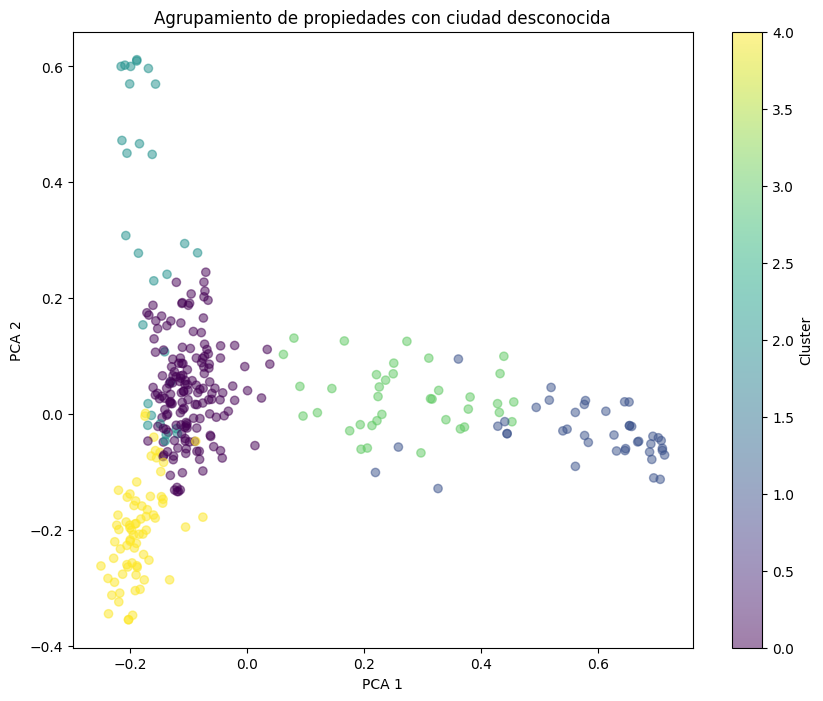


--- CLUSTER 0 ---
Número de propiedades: 161
Ubicaciones más comunes:
ubicacion
laureles, rosales, acacias                  4
laureles, castellana, rosales               3
entre amigos, sabaneta, vegas de doctora    3
laureles, castellana, acacias               3
chico , chico , chico                       2
Name: count, dtype: int64
Georeferencias más comunes:
georeferencia
laureles         9
poblado          6
centro           4
simon bolivar    3
castellana       3
Name: count, dtype: int64

--- CLUSTER 1 ---
Número de propiedades: 42
Ubicaciones más comunes:
ubicacion
veracruz, nieves, samper                4
cedritos, cedritos, contador            3
centro, jardin, bellavista              2
piedra pintada, gratamira, aguacatal    2
obrero, angeles, mayales i              2
Name: count, dtype: int64
Georeferencias más comunes:
georeferencia
cedro bolivar    2
antioquia        2
centro           2
villa alicia     2
chico            2
Name: count, dtype: int64

--- CLUSTER 2 ---
Nú

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1. Filtrar solo las propiedades con ciudad desconocida
df_sin_identificar = df[df['ciudad_consolidada'] == 'desconocida'].copy()

# 2. Preparar el texto combinado
df_sin_identificar['texto_combinado'] = (
    df_sin_identificar['ubicacion'] + " " +
    df_sin_identificar['descripcion'] + " " +
    df_sin_identificar['georeferencia']
)

# 3. Vectorizar con TF‑IDF
vectorizer = TfidfVectorizer(max_features=500)
X_tfidf = vectorizer.fit_transform(df_sin_identificar['texto_combinado'])

# 4. PCA para reducir a 2 dimensiones (visualización)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

# 5. K‑Means (5 clusters, semilla fija)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_tfidf)
df_sin_identificar['cluster'] = clusters

# 6. Mostrar scatter de clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1],
            c=clusters, cmap='viridis', alpha=0.5)
plt.title('Agrupamiento de propiedades con ciudad desconocida')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()

# 7. Inspeccionar cada cluster
for cluster_id in range(5):
    cluster_data = df_sin_identificar[df_sin_identificar['cluster'] == cluster_id]
    print(f"\n--- CLUSTER {cluster_id} ---")
    print(f"Número de propiedades: {len(cluster_data)}")
    print("Ubicaciones más comunes:")
    print(cluster_data['ubicacion'].value_counts().head(5))
    print("Georeferencias más comunes:")
    print(cluster_data['georeferencia'].value_counts().head(5))


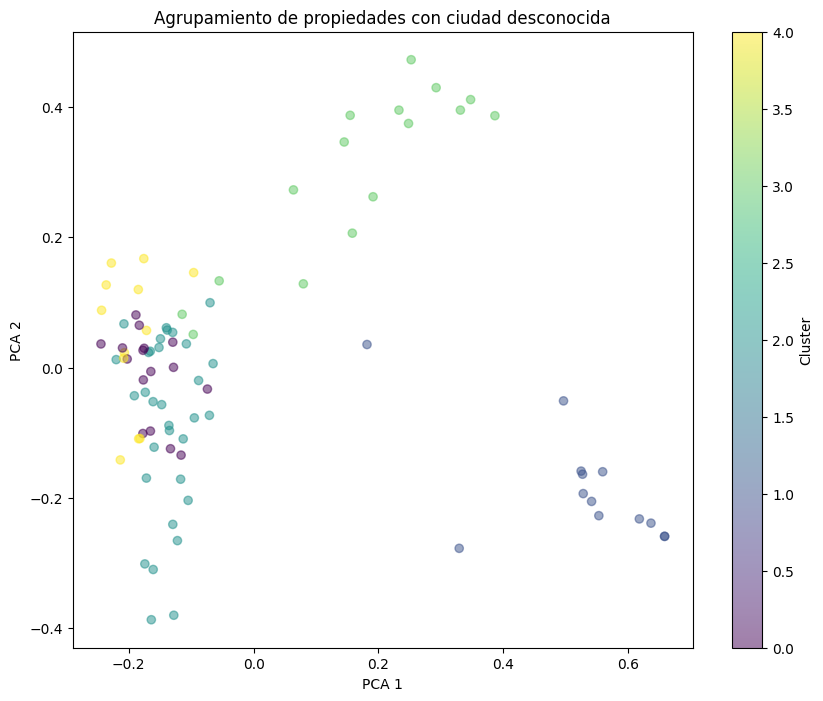


--- CLUSTER 0 ---
Número de propiedades: 16
Ubicaciones más comunes:
ubicacion
chico , chico , chico                                         2
sector transito municipal, prados del , torres de confandi    1
altos del prado, altos de riomar, altos del limon             1
santa barbara occidental, chico , santa barbara               1
dosquebradas, campestre a, san nicolas                        1
Name: count, dtype: int64
Georeferencias más comunes:
georeferencia
rincon chico      2
laureles          2
castellana        2
andes             1
villa carolina    1
Name: count, dtype: int64

--- CLUSTER 1 ---
Número de propiedades: 13
Ubicaciones más comunes:
ubicacion
obrero, angeles, mayales i                                                                                                                                                                                                                                                                                                            

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1. Filtrar solo las propiedades con ciudad desconocida
df_sin_identificar = df[df['ciudad_final'] == 'desconocida'].copy()

# 2. Preparar el texto combinado
df_sin_identificar['texto_combinado'] = (
    df_sin_identificar['ubicacion'] + " " +
    df_sin_identificar['descripcion'] + " " +
    df_sin_identificar['georeferencia']
)

# 3. Vectorizar con TF‑IDF
vectorizer = TfidfVectorizer(max_features=500)
X_tfidf = vectorizer.fit_transform(df_sin_identificar['texto_combinado'])

# 4. PCA para reducir a 2 dimensiones (visualización)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

# 5. K‑Means (5 clusters, semilla fija)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_tfidf)
df_sin_identificar['cluster'] = clusters

# 6. Mostrar scatter de clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1],
            c=clusters, cmap='viridis', alpha=0.5)
plt.title('Agrupamiento de propiedades con ciudad desconocida')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()

# 7. Inspeccionar cada cluster
for cluster_id in range(5):
    cluster_data = df_sin_identificar[df_sin_identificar['cluster'] == cluster_id]
    print(f"\n--- CLUSTER {cluster_id} ---")
    print(f"Número de propiedades: {len(cluster_data)}")
    print("Ubicaciones más comunes:")
    print(cluster_data['ubicacion'].value_counts().head(5))
    print("Georeferencias más comunes:")
    print(cluster_data['georeferencia'].value_counts().head(5))


In [52]:
df.head()

,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_detectada_ubicacion,ciudad_detectada_descripcion,ciudad_detectada_georeferencia,ciudad_consolidada,ciudad_final,confianza_ciudad
0,3300000000,"envigado, loma del escobero, palmas",4,4,2,450.0,zonas tranquilas exclusivas retiro antioquia e...,Casa campestre en venta,loma escobero,None,cali,None,cali,cali,1.00
1,350000000,"solares de morada vii y viii, br senderos de m...",2,3,2,100.0,hermosa casa castillo zona jamundí sur ciudad ...,Casa en venta,hacienda castillo,None,cali,None,cali,cali,1.00
2,1200000000,"calera, plazuela, alto de virgen",4,8,12,5127.0,expectacular casafinca campestre vía bogotá ca...,Casa campestre en venta,centro,None,bogota,None,bogota,bogota,0.75
3,194000000,"loma del atravesado, palmas, mesa",3,1,No encontrado,78.0,encantadora casa cuenta servicios completos in...,Casa en venta,vereda planta,None,None,None,desconocida,medellin,1.00
4,1290000000,"bogota, monaco, puente largo",4,3,2,445.0,,Casa en venta,niza,bogota,None,None,bogota,bogota,1.00


In [53]:
print('Cantidad de datos de Medellin:', df[df['ciudad_final'] == 'medellin'].shape[0])
print('Cantidad de datos de Bogota:', df[df['ciudad_final'] == 'bogota'].shape[0])

Cantidad de datos de Medellin: 183
Cantidad de datos de Bogota: 152


In [54]:
df['ciudad_final'].value_counts()

ciudad_final
medellin         183
bogota           152
desconocida       89
cali              21
pereira           11
barranquilla      10
cartagena          4
manizales          3
pasto              2
ibague             2
villavicencio      1
cucuta             1
Name: count, dtype: int64

In [55]:
df_final = df.copy()
df_final.columns.tolist()
'''
Columnas relevantes para el modelo:
precio',
 'ubicacion',
 'habitaciones',
 'baños',
 'parqueaderos',
 'area',
 'descripcion',
 'tipo_propiedad',
 'georeferencia',
 'ciudad_mejorada'
'''

df_final = df_final[['precio',
 'ubicacion',
 'habitaciones',
 'baños',
 'parqueaderos',
 'area',
 'descripcion',
 'tipo_propiedad',
 'georeferencia',
 'ciudad_final']]

df_final.head(10)


# Guardar el DataFrame final en un archivo CSV
df_final.to_csv('propiedades_limpias.csv', index=False, encoding='utf-8-sig')


Que nos falto? Datos extremos